In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import re
import sys 

import cptac
import cptac.utils as u

In [2]:
c1 = cptac.Endometrial()
c2 = cptac.Colon()

In [3]:
cancer1 = "Endometrial"
cancer2 = "Colon"
gene = 'ARID1A'

In [4]:
#GBM ttest
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest
prot = c1.get_proteomics()
prot_list = list(prot.columns)
prot_and_mutations = c1.join_omics_to_mutations(
    mutations_genes = [gene], omics_df_name = 'proteomics', omics_genes = prot_list)  

# Step 2 - Create binary column 
prot_and_mutations['binary_mutations'] = np.where(
            prot_and_mutations[gene+'_Mutation_Status'] == 'Wildtype_Tumor', 'Wildtype', 'Mutated')

# Step 3 - Format the dataframe correctly for the T-test(just omics and binary columns for tumors)
tumors = prot_and_mutations[prot_and_mutations.Sample_Status == 'Tumor'] #drop Normal samples
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
mut_status = tumors.drop(columns_to_drop, axis = 1)
mut_status = mut_status.dropna(axis=1,how='all')

In [5]:
col_list = list(mut_status.columns)
col_list.remove('binary_mutations')

print("Doing t-test comparisons for", cancer1)

# Call wrap_ttest, pass in formatted dataframe
wrap_results = u.wrap_ttest(mut_status, 'binary_mutations', col_list, return_all=True)

Doing t-test comparisons for GBM



C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\numpy\core\fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


8 significant comparisons!


In [19]:
print(wrap_results.loc[wrap_results['Comparison'] == gene+"_proteomics"])
wrap_results

          Comparison       P_Value
0  ARID1A_proteomics  1.025018e-10


,Comparison,P_Value
0,ARID1A_proteomics,1.025018e-10
1,MAP1S_proteomics,1.010149e-07
2,DPF2_proteomics,2.166609e-07
3,KDM4B_proteomics,4.414547e-07
4,RRM1_proteomics,4.455870e-07
...,...,...
10988,RP9_proteomics,9.976245e-01
10989,S100A7_proteomics,9.980427e-01
10990,SMDT1_proteomics,9.981687e-01
10991,TUBA1C_proteomics,9.994140e-01


In [7]:
# endo ttest
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest
prot2 = c2.get_proteomics()
prot_list2 = list(prot2.columns)
prot_and_mutations = c2.join_omics_to_mutations(
    mutations_genes = [gene], omics_df_name = 'proteomics', omics_genes = prot_list2)  

# Step 2 - Create binary column 
prot_and_mutations['binary_mutations'] = np.where(
            prot_and_mutations[gene+'_Mutation_Status'] == 'Wildtype_Tumor', 'Wildtype', 'Mutated')

# Step 3 - Format the dataframe correctly for the T-test(just omics and binary columns for tumors)
tumors = prot_and_mutations[prot_and_mutations.Sample_Status == 'Tumor'] #drop Normal samples
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
mut_status = tumors.drop(columns_to_drop, axis = 1)
mut_status2 = mut_status.dropna(axis=1,how='all')

In [9]:
col_list2 = list(mut_status2.columns)
col_list2.remove('binary_mutations')

print("Doing t-test comparisons for", cancer2)

# Call wrap_ttest, pass in formatted dataframe
wrap_results2 = u.wrap_ttest(mut_status2, 'binary_mutations', col_list2, return_all=True)

Doing t-test comparisons for Colon
No significant comparisons.


In [20]:
print(wrap_results2.loc[wrap_results2['Comparison'] == gene+"_proteomics"])
wrap_results2

            Comparison   P_Value
889  ARID1A_proteomics  0.001305


,Comparison,P_Value
0,ACSS2_proteomics,0.000171
1,MOV10_proteomics,0.000274
2,ELP3_proteomics,0.000308
3,EIF4A1_proteomics,0.002589
4,AAMP_proteomics,0.003227
...,...,...
8062,VPS51_proteomics,0.992112
8063,TMED1_proteomics,0.993533
8064,DYNC1H1_proteomics,0.997625
8065,MAP2K6_proteomics,0.998231


In [13]:
#combine pval results
combined = wrap_results.merge(wrap_results2, on='Comparison')
combined = combined.replace(regex=True,to_replace='_proteomics', value='')

In [14]:
# Green = interacting protein
interacting_list = u.get_interacting_proteins(gene)
combined["color"] = np.where(combined["Comparison"].isin(interacting_list), "green", "black")
print(interacting_list)
#combined.loc[combined['color'] == 'green']

['SMARCC1', 'SUPT16H', 'CCND1', 'SMARCD3', 'CREBBP', 'SMARCB1', 'KAT2B', 'DNMT3A', 'SMARCA2', 'SMARCC2', 'KMT2D', 'ARID1A', 'SMARCE1', 'PHF10', 'BAZ1B', 'ARID1B', 'NF1', 'CDC5L', 'SMARCD1', 'SMARCD2', 'SMARCA4', 'ACTL6A', 'BCL7B', 'SS18', 'DPF2', 'DPF3', 'KLF1', 'GATA1', 'ING1', 'PGR', 'BCL7C', 'HIC1']


In [18]:
limit_x = combined.loc[combined['P_Value_x'] <= .05]
limit_y = combined.loc[combined['P_Value_y'] <= .05]
limit_both = limit_x.loc[limit_x['P_Value_y'] <= .05]
print(limit_both.loc[limit_both['color'] == 'green'])
limit_both

     Comparison     P_Value_x  P_Value_y  color
0        ARID1A  1.025018e-10   0.001305  green
2          DPF2  2.166609e-07   0.048870  green
5862    SMARCC2  8.270473e-05   0.046582  green
5864    SMARCE1  1.498027e-04   0.014231  green


,Comparison,P_Value_x,P_Value_y,color
0,ARID1A,1.025018e-10,0.001305,green
2,DPF2,2.166609e-07,0.048870,green
3,RRM1,4.455870e-07,0.000683,black
5,ACYP2,1.349353e-04,0.049855,black
9,ALDH1B1,3.733383e-04,0.014190,black
...,...,...,...,...
6605,SMAP1,4.099963e-02,0.049020,black
6607,SOD3,4.141997e-02,0.029779,black
6613,RPL35,4.330776e-02,0.043198,black
6619,RMDN2,4.447102e-02,0.017967,black


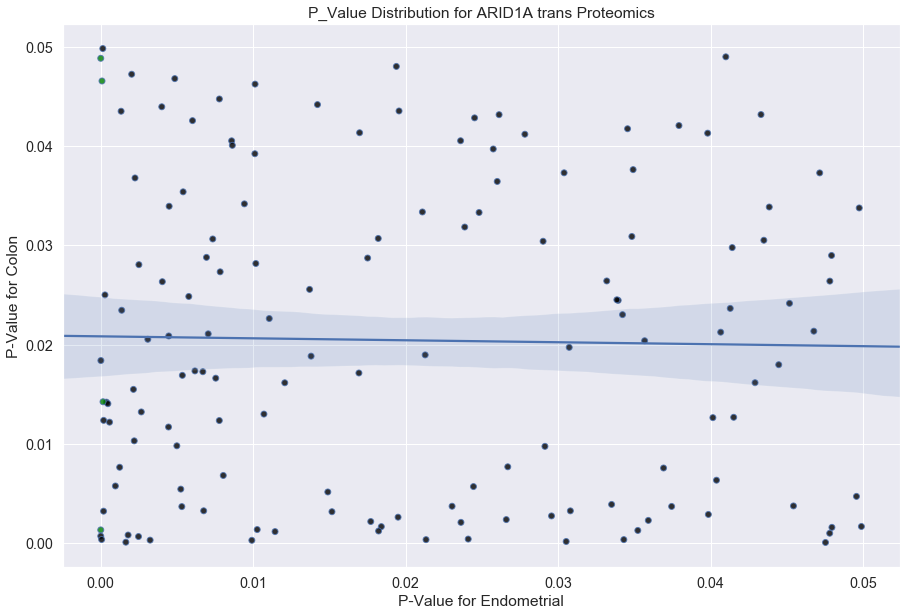

In [16]:
# Format figure size and font
plt.rcParams['figure.figsize']=(15,10)
sns.set(font_scale = 1.3)

# Format title and axis
plot = sns.regplot(x="P_Value_x", y="P_Value_y", data=limit_both, scatter_kws={'facecolors':limit_both['color']})
plot.set_title("P_Value Distribution for "+gene+" trans Proteomics")
plot.set(xlabel = 'P-Value for '+cancer1)
plot.set(ylabel = 'P-Value for '+cancer2)

plt.show()
plt.clf()
plt.close()

ARID1A: 8 significant results for endometrial. No significant results for colon. 4 interacting proteins in graph with alpha = 0.05 borders.